# (MBTI) Myers-Briggs Personality Type Prediction

The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

* Introversion (I) – Extroversion (E)
* Intuition (N) – Sensing (S)
* Thinking (T) – Feeling (F)
* Judging (J) – Perceiving (P)


So for example, someone who prefers introversion, intuition, thinking and perceiving would be labelled an INTP in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

It is one of, if not the, the most popular personality test in the world. It is used in businesses, online, for fun, for research and lots more. A simple google search reveals all of the different ways the test has been used over time. It’s safe to say that this test is still very relevant in the world in terms of its use.

From scientific or psychological perspective it is based on the work done on cognitive functions by Carl Jung i.e. Jungian Typology. This was a model of 8 distinct functions, thought processes or ways of thinking that were suggested to be present in the mind. Later this work was transformed into several different personality systems to make it more accessible, the most popular of which is of course the MBTI.

Recently, its use/validity has come into question because of unreliability in experiments surrounding it, among other reasons. But it is still clung to as being a very useful tool in a lot of areas, and the purpose of this dataset is to help see if any patterns can be detected in specific types and their style of writing, which overall explores the validity of the test in analysing, predicting or categorising behaviour.

Content:<br>
This dataset contains over 8600 rows of data, on each row is a person’s:
* Type (This persons 4 letter MBTI code/type)
* A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

In [44]:
# importing dependencies here
import numpy as np
import pandas as pd

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# feature engineering
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")
nltk.download("vader_lexicon")

# sentiment scoring
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# scikit
# vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# scaling to handle negative values (for Naive Bayes)
from sklearn.preprocessing import MinMaxScaler

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# algorithms/models
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# model performance evaluation and selection
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# code formatter
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<IPython.core.display.Javascript object>

In [2]:
# reading the dataset
personality_data = pd.read_csv("../data/mbti_1.csv")

<IPython.core.display.Javascript object>

In [3]:
# lookign at the top 5 rows of the dataset
personality_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


<IPython.core.display.Javascript object>

In [4]:
# checking the number of rows and columns
personality_data.shape

(8675, 2)

<IPython.core.display.Javascript object>

#### Each row as 50 posts. Splitting these posts into their own row.

In [5]:
# splitting rows - one row for each post
# personality_data = (
#     pd.concat(
#         [
#             pd.Series(row["type"], row["posts"].split("|||"))
#             for _, row in personality_data.iterrows()
#         ]
#     )
#     .reset_index()
#     .rename({"index": "posts", 0: "type"}, axis=1)
# )

<IPython.core.display.Javascript object>

In [6]:
# checking the number of rows and columns again
# personality_data.shape

<IPython.core.display.Javascript object>

Splitting of each row into 50 rows has added a lot more data to our dataset.

In [7]:
# personality_data.head()

<IPython.core.display.Javascript object>

#### Checking for Null values

In [8]:
# checking for missing values
personality_data.isnull().sum()

type     0
posts    0
dtype: int64

<IPython.core.display.Javascript object>

Luckily there are no missing values present in this dataset.

#### Checking for Class Imbalance

In [9]:
# checking number of records for each of the 16 personality types
personality_data["type"].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

<IPython.core.display.Javascript object>

The dataset seems to be Imbalanced.

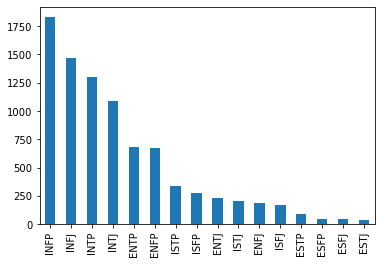

<IPython.core.display.Javascript object>

In [10]:
# visually showing the class imbalance
personality_data["type"].value_counts().plot(kind="bar")
plt.show()

In [11]:
# fixing the class imbalance but converting 16 classes into 4 more balanced classes
personality_data["is_Extrovert"] = personality_data["type"].apply(
    lambda x: 1 if x[0] == "E" else 0
)
personality_data["is_Sensing"] = personality_data["type"].apply(
    lambda x: 1 if x[1] == "S" else 0
)
personality_data["is_Thinking"] = personality_data["type"].apply(
    lambda x: 1 if x[2] == "T" else 0
)
personality_data["is_Judging"] = personality_data["type"].apply(
    lambda x: 1 if x[3] == "J" else 0
)

# rearranging the dataframe columns
personality_data = personality_data[
    ["type", "is_Extrovert", "is_Sensing", "is_Thinking", "is_Judging", "posts"]
]
personality_data.head()

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...


<IPython.core.display.Javascript object>

In [12]:
# checking individual counts
introvert_count = personality_data["is_Extrovert"].value_counts()[0]
extrovert_count = personality_data["is_Extrovert"].value_counts()[1]

intuition_count = personality_data["is_Sensing"].value_counts()[0]
sensing_count = personality_data["is_Sensing"].value_counts()[1]

feeling_count = personality_data["is_Thinking"].value_counts()[0]
thinking_count = personality_data["is_Thinking"].value_counts()[1]

perceiving_count = personality_data["is_Judging"].value_counts()[0]
judging_count = personality_data["is_Judging"].value_counts()[1]

<IPython.core.display.Javascript object>

In [13]:
# printing all the counts
print(f"Introvert Count: {introvert_count}")
print(f"Extrovert Count: {extrovert_count}")
print(f"Intuition Count: {intuition_count}")
print(f"Sensing Count: {sensing_count}")
print(f"Feeling Count: {feeling_count}")
print(f"Thinking Count: {thinking_count}")
print(f"Perceiving Count: {perceiving_count}")
print(f"Judging Count: {judging_count}")

Introvert Count: 6676
Extrovert Count: 1999
Intuition Count: 7478
Sensing Count: 1197
Feeling Count: 4694
Thinking Count: 3981
Perceiving Count: 5241
Judging Count: 3434


<IPython.core.display.Javascript object>

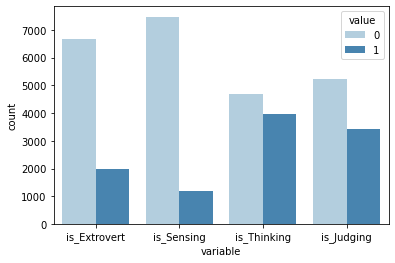

<IPython.core.display.Javascript object>

In [14]:
sns.countplot(
    x="variable",
    hue="value",
    data=pd.melt(
        personality_data[["is_Extrovert", "is_Sensing", "is_Thinking", "is_Judging"]]
    ),
    palette="Blues",
)

plt.show()

The class imbalance issue still seem to exist but the data now looks much better than the minority class counts of previous data.

#### Checking for presence of correlations

In [15]:
corr = personality_data[
    ["is_Extrovert", "is_Sensing", "is_Thinking", "is_Judging"]
].corr()
corr.style.background_gradient(cmap="Blues").set_precision(4)

,is_Extrovert,is_Sensing,is_Thinking,is_Judging
is_Extrovert,1.0000,-0.0459,0.0696,-0.1619
is_Sensing,-0.0459,1.0000,0.0810,-0.0149
is_Thinking,0.0696,0.0810,1.0000,-0.0047
is_Judging,-0.1619,-0.0149,-0.0047,1.0000


<IPython.core.display.Javascript object>

There does not seem to be any strong correlation between the four personality dimenions.

### Feature Engineering

#### Data Cleaning

In [18]:
# for first two cleaning steps I updated the posts column itself because I will be using it to count punctuations sans links

# converting posts into lower case
personality_data["posts"] = personality_data["posts"].str.lower()

# replacing urls with domain name
personality_data["posts"] = personality_data["posts"].str.replace(
    re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+).*"), lambda match: match.group(2)
)

# replacing emails with space
personality_data["clean_posts"] = personality_data["posts"].str.replace(re.compile(r"\S+@\S+"), " ")

# replacing MBTIs with space
mbti = personality_data["type"].unique()
for type_word in mbti:
    personality_data["clean_posts"] = personality_data["clean_posts"].str.replace(type_word.lower(), " ")
    
# replacing ||| with space
personality_data["clean_posts"] = personality_data["clean_posts"].str.replace(re.compile(r"\|\|\|"), " ")

# replacing punctuations with space
personality_data["clean_posts"] = personality_data["clean_posts"].str.replace(re.compile(r"[^a-z\s]"), " ")


<IPython.core.display.Javascript object>

#### Lemmitizing

* CAUTION - This will take long to run!!

In [22]:
# lemmitizing

t = time.time()

lemmatizer = WordNetLemmatizer()

personality_data["clean_posts"] = personality_data["clean_posts"].apply(lambda x: " ".join(
    [
        lemmatizer.lemmatize(word)
        for word in x.split(" ")
                if word not in stopwords.words("english")
    ]
))

print(f"Lemmitizing Time: {time.time() - t} seconds)

Time Taken:  2439.205047607422


<IPython.core.display.Javascript object>

In [23]:
personality_data.head()

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts
0,INFJ,0,0,0,1,'youtube,youtube
1,ENTP,1,0,1,0,'i'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...
2,INTP,0,0,1,0,'good one _____ youtube,good one youtube
3,INTJ,0,0,1,1,"'dear intp, i enjoyed our conversation the o...",dear enjoyed conversation day esoteric...
4,ENTJ,1,0,1,1,'you're fired.|||that's another silly misconce...,fired another silly misconception approachi...


<IPython.core.display.Javascript object>

In [24]:
# lemmitizing took long. So saving the clean and lemmitized file to save tine in further processing.
personality_data.to_csv("data_ekta/clean_data_1.csv", index=False)

<IPython.core.display.Javascript object>

#### Reading the saved file and using that for next step in analysis.

In [25]:
# reading the clean & lemmitized file
personality_data = pd.read_csv("data_ekta/clean_data_1.csv")

<IPython.core.display.Javascript object>

In [26]:
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts
0,INFJ,0,0,0,1,'youtube,youtube
1,ENTP,1,0,1,0,'i'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...


<IPython.core.display.Javascript object>

In [27]:
# checking the data types to make sure they still look good
personality_data.dtypes

type            object
is_Extrovert     int64
is_Sensing       int64
is_Thinking      int64
is_Judging       int64
posts           object
clean_posts     object
dtype: object

<IPython.core.display.Javascript object>

In [28]:
# checking for null values again
personality_data.isnull().sum()

type             0
is_Extrovert     0
is_Sensing       0
is_Thinking      0
is_Judging       0
posts            0
clean_posts     13
dtype: int64

<IPython.core.display.Javascript object>

Splitting and Cleaning have introduced null vaues. Dropping rows with null values.

In [29]:
# dropping rows with null values
personality_data.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [30]:
# checking again to make sure there are no more null values
personality_data.isnull().sum()

type            0
is_Extrovert    0
is_Sensing      0
is_Thinking     0
is_Judging      0
posts           0
clean_posts     0
dtype: int64

<IPython.core.display.Javascript object>

#### COUNTING

* Note: posts used for various counts have links removed. 

#### Question/Exclamation/Colon/Emoji Count

In [31]:
def unique_words(s):
    unique = set(s.split(" "))
    return len(unique)


def emojis(post):
    # does not include emojis made purely from symbols, only :word:
    emoji_count = 0
    words = post.split()
    for e in words:
        if "http" not in e:
            if e.count(":") == 2:
                emoji_count += 1
    return emoji_count


def colons(post):
    # Includes colons used in emojis
    colon_count = 0
    words = post.split()
    for e in words:
        if "http" not in e:
            colon_count += e.count(":")
    return colon_count

<IPython.core.display.Javascript object>

In [32]:
personality_data["qm"] = personality_data["posts"].apply(lambda s: s.count("?"))
personality_data["em"] = personality_data["posts"].apply(lambda s: s.count("!"))
personality_data["colons"] = personality_data["posts"].apply(colons)
personality_data["emojis"] = personality_data["posts"].apply(emojis)

<IPython.core.display.Javascript object>

#### Word Count

In [33]:
personality_data["word_count"] = personality_data["posts"].apply(
    lambda s: s.count(" ") + 1
)
personality_data["unique_words"] = personality_data["posts"].apply(unique_words)

<IPython.core.display.Javascript object>

#### Upper Case Count

In [34]:
personality_data["upper"] = personality_data["posts"].apply(
    lambda x: len([x for x in x.split() if x.isupper()])
)

<IPython.core.display.Javascript object>

#### Link Count

In [35]:
# counting links per post
personality_data["link_count"] = personality_data["posts"].apply(
    lambda s: s.count("http")
)

<IPython.core.display.Javascript object>

#### Ellipses Count

In [36]:
# counting ellipses per post
ellipses_count = [
    len(re.findall(r"\.\.\.\ ", posts)) for posts in personality_data["posts"]
]
personality_data["ellipses"] = ellipses_count

<IPython.core.display.Javascript object>

#### Image Count

In [37]:
# counting images per post
personality_data["img_count"] = [
    len(re.findall(r"(\.jpg)|(\.jpeg)|(\.gif)|(\.png)", post))
    for post in personality_data["posts"]
]

<IPython.core.display.Javascript object>

In [38]:
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,qm,em,colons,emojis,word_count,unique_words,upper,link_count,ellipses,img_count
0,INFJ,0,0,0,1,'youtube,youtube,0,0,0,0,1,1,0,0,0,0
1,ENTP,1,0,1,0,'i'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...,0,0,0,0,165,119,0,0,0,0


<IPython.core.display.Javascript object>

#### Dropping posts with less than 2 words

In [39]:
personality_data.drop(
    personality_data[personality_data["word_count"] < 2].index, inplace=True
)

<IPython.core.display.Javascript object>

In [40]:
personality_data.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [41]:
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,qm,em,colons,emojis,word_count,unique_words,upper,link_count,ellipses,img_count
0,ENTP,1,0,1,0,'i'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...,0,0,0,0,165,119,0,0,0,0
1,INTP,0,0,1,0,'good one _____ youtube,good one youtube,0,0,0,0,7,5,0,0,0,0


<IPython.core.display.Javascript object>

#### Sentiments Analysis Score

In [45]:
t = time.time()

analyzer = SentimentIntensityAnalyzer()

nlp_sentiment_score = []

for post in personality_data["clean_posts"]:
    score = analyzer.polarity_scores(post)
    nlp_sentiment_score.append(score)

print(f"Sentiment Scoring Time: {time.time() - t:.2f} seconds")

Sentiment Scoring Time: 245.17 seconds


<IPython.core.display.Javascript object>

In [46]:
personality_data["compound_sentiment"] = [
    score["compound"] for score in nlp_sentiment_score
]
personality_data["pos_sentiment"] = [score["pos"] for score in nlp_sentiment_score]
personality_data["neg_sentiment"] = [score["neg"] for score in nlp_sentiment_score]
personality_data["neu_sentiment"] = [score["neu"] for score in nlp_sentiment_score]

<IPython.core.display.Javascript object>

In [47]:
# Sentiment scores have negative values that Naive Bayes can't handle. So scaling it.

min_max_scaler = MinMaxScaler()
personality_data["compound_sentiment"] = min_max_scaler.fit_transform(
    np.array(personality_data["compound_sentiment"]).reshape(-1, 1)
)
personality_data["pos_sentiment"] = min_max_scaler.fit_transform(
    np.array(personality_data["pos_sentiment"]).reshape(-1, 1)
)
personality_data["neg_sentiment"] = min_max_scaler.fit_transform(
    np.array(personality_data["neg_sentiment"]).reshape(-1, 1)
)
personality_data["neu_sentiment"] = min_max_scaler.fit_transform(
    np.array(personality_data["neu_sentiment"]).reshape(-1, 1)
)

<IPython.core.display.Javascript object>

In [48]:
# checking to see if sentiment scores introduced any null value
personality_data.isnull().sum()

type                  0
is_Extrovert          0
is_Sensing            0
is_Thinking           0
is_Judging            0
posts                 0
clean_posts           0
qm                    0
em                    0
colons                0
emojis                0
word_count            0
unique_words          0
upper                 0
link_count            0
ellipses              0
img_count             0
compound_sentiment    0
pos_sentiment         0
neg_sentiment         0
neu_sentiment         0
dtype: int64

<IPython.core.display.Javascript object>

#### Grammar Tagging

In [49]:
# tagging grammar in the words
# stop_words = set(stopwords.words('english'))
# tokenized = sent_tokenize(str(personality_data["clean_posts"]))

# for row in personality_data["clean_posts"]:
#     tokenized = sent_tokenize(str(personality_data["clean_posts"]))
#     wordsList = nltk.word_tokenize(str(tokenized))
#     wordsList = [w for w in wordsList if w.isalpha() and not w in stop_words]
#     tagged = nltk.pos_tag(wordsList)
#     print(tagged)


# for i in tokenized:

#     # Word tokenizers is used to find the words and punctuation in a string
#     wordsList = nltk.word_tokenize(i)

#     # removing stop words and punctuations from wordList
#     wordsList = [w for w in wordsList if w.isalpha() and not w in stop_words]

#     #  Using a Tagger which is part-of-speech tagger or POS-tagger
#     tagged = nltk.pos_tag(wordsList)

#     print(tagged)

<IPython.core.display.Javascript object>

In [50]:
# part of speech tagging
# personality_data["pos_tag"] = personality_data["clean_posts"].apply(
#                                 lambda x: [nltk.pos_tag(word_tokenize(row)) for row in x])
# personality_data['tagged_words'][0]

<IPython.core.display.Javascript object>

In [51]:
# from nltk.tag.perceptron import PerceptronTagger
# tagger = PerceptronTagger()

# personality_data["pos_tag"] = personality_data["clean_posts"].apply(
#                                 lambda x: [tagger.tag(word_tokenize(row)) for row in x])

<IPython.core.display.Javascript object>

In [52]:
# personality_data.head()

<IPython.core.display.Javascript object>

In [53]:
# combining similar pos into one category based on the Stanford POS tags
# tag_dict={'ADJ':['JJ','JJR','JJS'], 'ADP':['EX','TO'], 'ADV':['RB','RBR','RBS','WRB'], 'CONJ':['CC','IN'],'DET':['DT','PDT','WDT'],
#               'NOUN':['NN','NNS','NNP','NNPS'], 'NUM':['CD'],'PRT':['RP'],'PRON':['PRP','PRP$','WP','WP$'],
#               'VERB':['MD','VB','VBD','VBG','VBN','VBP','VBZ'],'.':['#','$',"''",'(',')',',','.',':'],'X':['FW','LS','UH']}

# for word,tag in personality_data["pos_tag"]:
#     for key,value in tag_dict.items():
#         if tag in value:
#             tag = key

<IPython.core.display.Javascript object>

In [54]:
# personality_data["adj_count"] =

<IPython.core.display.Javascript object>

In [55]:
# Sentiment scoring took long. So saving the scored file to save time in the next steps.
personality_data.to_csv("data_ekta/clean_data_2.csv", index=False)

<IPython.core.display.Javascript object>

### Visualizations

In [56]:
# reading the scored file
personality_data = pd.read_csv("data_ekta/clean_data_2.csv")

<IPython.core.display.Javascript object>

#### Word Clouds

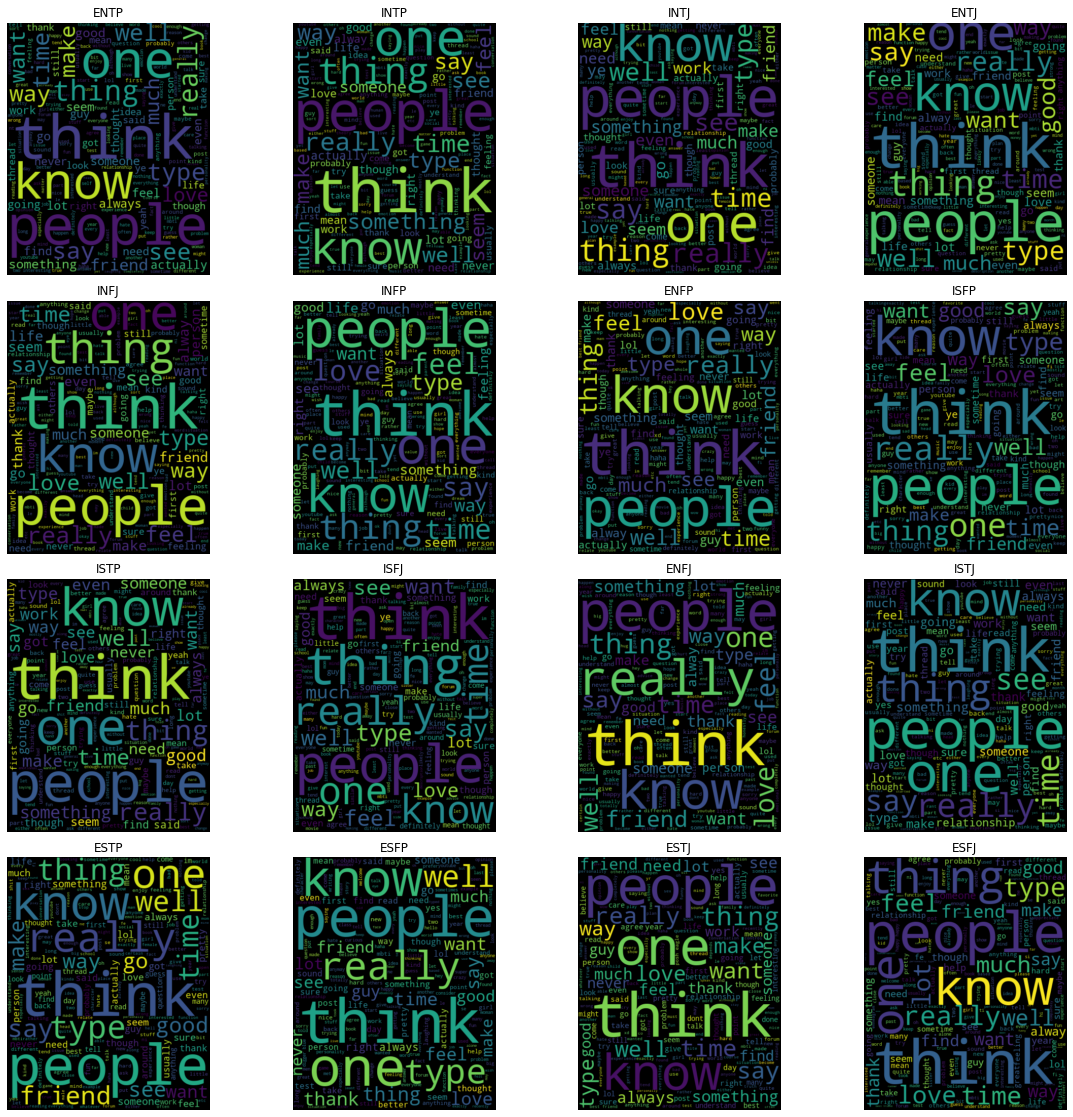

<IPython.core.display.Javascript object>

In [57]:
from wordcloud import WordCloud

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax.ravel()

for i, mbti_type in enumerate(personality_data["type"].unique()):
    wordcloud_words = " ".join(
        personality_data[personality_data["type"] == mbti_type]["clean_posts"]
    )
    wordcloud = WordCloud(height=500).generate(wordcloud_words)
    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].axis("off")
    ax[i].set_title(mbti_type)

#### Word Count by Type

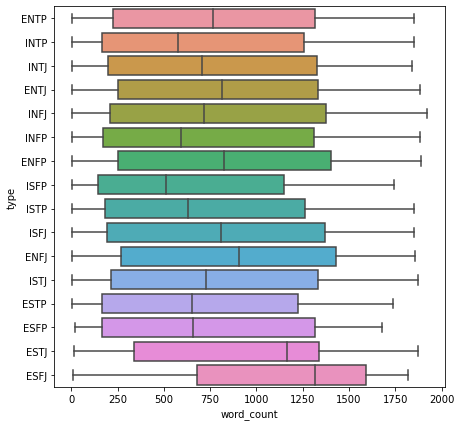

<IPython.core.display.Javascript object>

In [58]:
# boxplot of word counts
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="word_count", data=personality_data, showfliers=False)

#### Compound Sentiment Score by Type

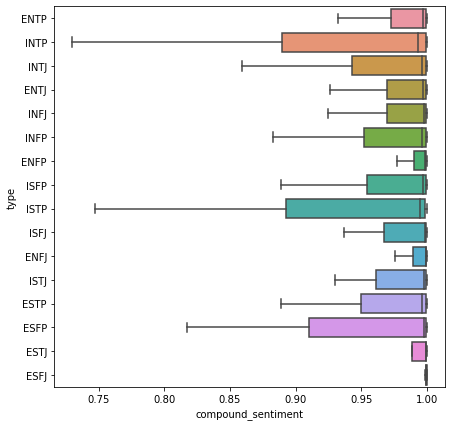

<IPython.core.display.Javascript object>

In [59]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="compound_sentiment", data=personality_data, showfliers=False)

#### Positive Sentiment Score by Type

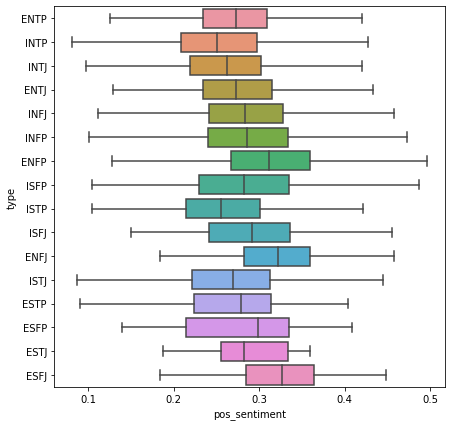

<IPython.core.display.Javascript object>

In [60]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="pos_sentiment", data=personality_data, showfliers=False)

#### Negative Sentiment Score by Type

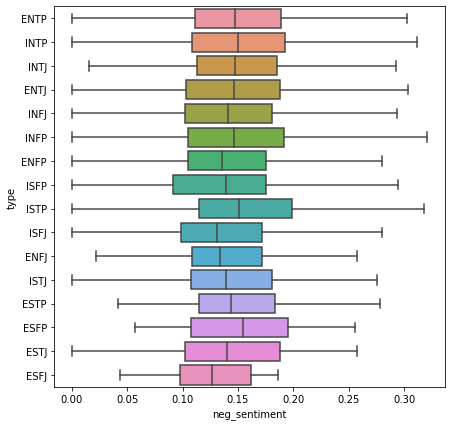

<IPython.core.display.Javascript object>

In [61]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="neg_sentiment", data=personality_data, showfliers=False)

#### Neutral Sentiment Score by Type

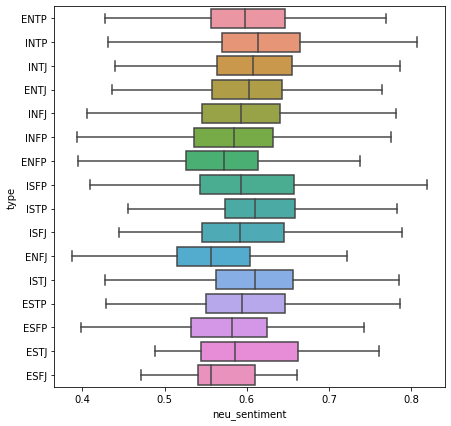

<IPython.core.display.Javascript object>

In [62]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="neu_sentiment", data=personality_data, showfliers=False)

#### Question Marks by Type

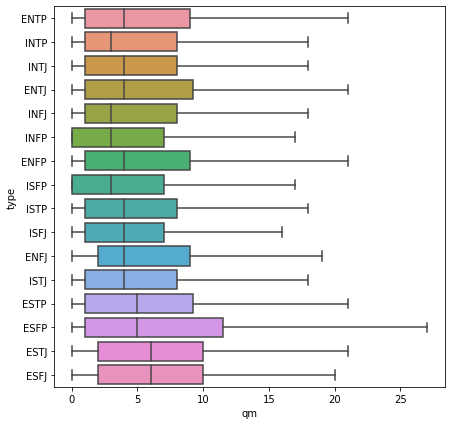

<IPython.core.display.Javascript object>

In [63]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="qm", data=personality_data, showfliers=False)

#### Exclamation by Type

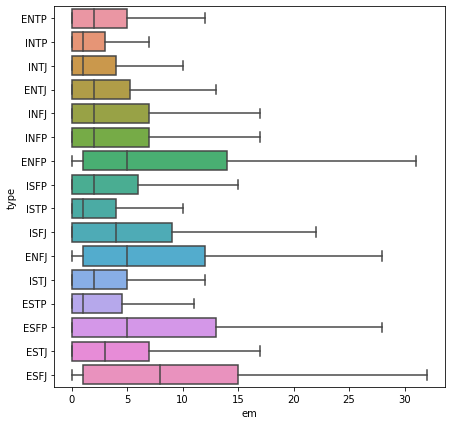

<IPython.core.display.Javascript object>

In [64]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="em", data=personality_data, showfliers=False)

#### Colons by Type

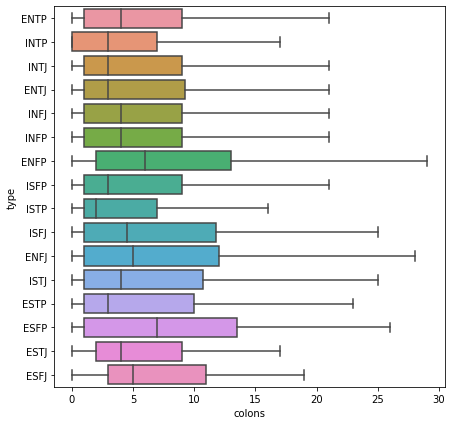

<IPython.core.display.Javascript object>

In [65]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="colons", data=personality_data, showfliers=False)

#### Emojis by Type

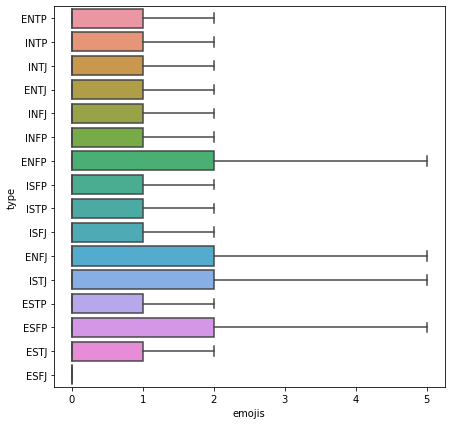

<IPython.core.display.Javascript object>

In [66]:
plt.figure(figsize=(7, 7))
sns.boxplot(y="type", x="emojis", data=personality_data, showfliers=False)

### Vectorize

In [67]:
# Using TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    min_df=0.05, max_df=0.90, analyzer="word", ngram_range=(1, 2)
)
tfidf_words = tfidf_vectorizer.fit_transform(personality_data["clean_posts"])

tfidf_vectorized_data = pd.DataFrame(
    data=tfidf_words.toarray(), columns=tfidf_vectorizer.get_feature_names()
)

<IPython.core.display.Javascript object>

In [68]:
tfidf_vectorized_data.head()

,ability,able,absolutely,accept,according,accurate,across,act,action,activity,...,year,year ago,year old,yep,yes,yesterday,yet,young,younger,youtube
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.083090,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.705883
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.067984,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.042996
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.119531
4,0.0,0.033046,0.0,0.0,0.050323,0.0,0.0,0.0,0.000000,0.0,...,0.045519,0.084275,0.0,0.0,0.046995,0.0,0.0,0.0,0.0,0.000000


<IPython.core.display.Javascript object>

In [71]:
# Using CountVectorizer

count_vectorizer = CountVectorizer(
    analyzer="word",
    stop_words="english",
    input="content",
    decode_error="ignore",
    min_df=0.05,
    max_df=0.90,
    token_pattern=r"\w{1,}",
    max_features=1028,
    ngram_range=(1, 2),
)

count_words = count_vectorizer.fit_transform(personality_data["clean_posts"])
count_vectorized_data = pd.DataFrame(
    data=count_words.toarray(), columns=count_vectorizer.get_feature_names()
)

<IPython.core.display.Javascript object>

In [72]:
count_vectorized_data.head()

,ability,able,absolutely,accept,according,accurate,act,action,activity,actual,...,yeah,year,year ago,year old,yep,yes,yesterday,young,younger,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,0,0,0,0,1,...,0,2,2,0,0,2,0,0,0,0


<IPython.core.display.Javascript object>

### Modelling

In [73]:
personality_data.head(3)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,qm,em,colons,...,word_count,unique_words,upper,link_count,ellipses,img_count,compound_sentiment,pos_sentiment,neg_sentiment,neu_sentiment
0,ENTP,1,0,1,0,'i'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...,0,0,0,...,165,119,0,0,0,0,0.958475,0.251,0.142509,0.632
1,INTP,0,0,1,0,'good one _____ youtube,good one youtube,0,0,0,...,7,5,0,0,0,0,0.720082,0.592,0.000000,0.408
2,INTJ,0,0,1,1,"'dear intp, i enjoyed our conversation the o...",dear enjoyed conversation day esoteric...,6,2,3,...,603,346,0,0,2,0,0.997899,0.274,0.123021,0.625


<IPython.core.display.Javascript object>

#### Setting predictors and target variable


In [87]:
# combining counts, sentiment score and TF-IDF vectorized data
X_tf = pd.concat([personality_data.iloc[:, 7:], tfidf_vectorized_data], axis=1)

# combining counts, sentiment score and Count vectorized data
X_ct = pd.concat([personality_data.iloc[:, 7:], count_vectorized_data], axis=1)

# since it is a multiclass problem with class imbalance, we will use 4 type variables as predictors instead of 1 "type" col
y = personality_data.iloc[:, 1:5]

print(X_tf.shape)
print(X_ct.shape)
print(y.shape)

(8284, 1042)
(8284, 929)
(8284, 4)


<IPython.core.display.Javascript object>

In [90]:
def create_model(model, X, target, num_splits):

    sss = StratifiedShuffleSplit(n_splits=num_splits, test_size=0.20, random_state=0)

    mbti_type = {
        "is_Extrovert": "Extrovert vs Introvert",
        "is_Sensing": "Sensing vs Intuition",
        "is_Thinking": "Thinking vs Feeling",
        "is_Judging": "Judging vs Perceiving",
    }

    # to time the individual model run time
    t = time.time()

    for col in target.columns:

        print(f"\n{mbti_type[col]}")
        y = target[col]
        auc_list, acc_list, f1_list = [], [], []

        for train_index, test_index in sss.split(X, y):

            X_train, X_test, y_train, y_test = (
                X.iloc[train_index],
                X.iloc[test_index],
                y[train_index],
                y[test_index],
            )

            model.fit(X_train, y_train)

            preds = model.predict_proba(X_test)[
                :, 1
            ]  # returns the probablity of second class
            auc = roc_auc_score(y_test, preds)
            acc = accuracy_score(y_test, preds.round())
            f1 = f1_score(y_test, preds.round())

            auc_list.append(auc)
            acc_list.append(acc)
            f1_list.append(f1)
      
        print(
            f"Avg AUC: {np.mean(auc_list):.2f}, Avg Accuracy: {np.mean(acc_list):.2f}, Avg F1: {np.mean(f1_list):.2f}"
        )
  
    print(f"\Time Taken: {time.time()-t:.2f} seconds")

<IPython.core.display.Javascript object>

### Logistic Regression

In [91]:
# using TF-IDF vectorized data
clf_tf = LogisticRegression()
create_model(clf_tf, X_tf, y, num_splits=5)


Extrovert vs Introvert
Avg AUC: 0.56, Avg Accuracy: 0.77, Avg F1: 0.06

Sensing vs Intuition
Avg AUC: 0.51, Avg Accuracy: 0.86, Avg F1: 0.00

Thinking vs Feeling
Avg AUC: 0.64, Avg Accuracy: 0.61, Avg F1: 0.52

Judging vs Perceiving
Avg AUC: 0.54, Avg Accuracy: 0.60, Avg F1: 0.01

Modelling Time: 18.56 seconds


<IPython.core.display.Javascript object>

In [92]:
# using Count vectorized data
clf_ct = LogisticRegression()
create_model(clf_ct, X_ct, y, num_splits=5)


Extrovert vs Introvert
Avg AUC: 0.66, Avg Accuracy: 0.77, Avg F1: 0.25

Sensing vs Intuition
Avg AUC: 0.65, Avg Accuracy: 0.85, Avg F1: 0.12

Thinking vs Feeling
Avg AUC: 0.78, Avg Accuracy: 0.70, Avg F1: 0.65

Judging vs Perceiving
Avg AUC: 0.64, Avg Accuracy: 0.64, Avg F1: 0.42

Modelling Time: 16.89 seconds


<IPython.core.display.Javascript object>

### Naive Bayes

In [93]:
# using TF-IDF vectorized data
nb_tf = MultinomialNB()
create_model(nb_tf, X_tf, y, num_splits=5)


Extrovert vs Introvert
Avg AUC: 0.58, Avg Accuracy: 0.70, Avg F1: 0.30

Sensing vs Intuition
Avg AUC: 0.57, Avg Accuracy: 0.85, Avg F1: 0.05

Thinking vs Feeling
Avg AUC: 0.66, Avg Accuracy: 0.59, Avg F1: 0.63

Judging vs Perceiving
Avg AUC: 0.55, Avg Accuracy: 0.58, Avg F1: 0.39

Modelling Time: 2.67 seconds


<IPython.core.display.Javascript object>

In [94]:
# using Count vectorized data
nb_ct = MultinomialNB()
create_model(nb_ct, X_ct, y, num_splits=5)


Extrovert vs Introvert
Avg AUC: 0.65, Avg Accuracy: 0.71, Avg F1: 0.38

Sensing vs Intuition
Avg AUC: 0.67, Avg Accuracy: 0.79, Avg F1: 0.27

Thinking vs Feeling
Avg AUC: 0.75, Avg Accuracy: 0.68, Avg F1: 0.68

Judging vs Perceiving
Avg AUC: 0.62, Avg Accuracy: 0.62, Avg F1: 0.46

Modelling Time: 2.35 seconds


<IPython.core.display.Javascript object>

### Random Forest

In [95]:
# using TF-IDF vectorized data
rf_tf = RandomForestClassifier()
create_model(rf_tf, X_tf, y, num_splits=5)


Extrovert vs Introvert
Avg AUC: 0.61, Avg Accuracy: 0.77, Avg F1: 0.00

Sensing vs Intuition
Avg AUC: 0.58, Avg Accuracy: 0.86, Avg F1: 0.01

Thinking vs Feeling
Avg AUC: 0.73, Avg Accuracy: 0.67, Avg F1: 0.60

Judging vs Perceiving
Avg AUC: 0.58, Avg Accuracy: 0.61, Avg F1: 0.20

Modelling Time: 192.21 seconds


<IPython.core.display.Javascript object>

In [96]:
# using TF-IDF vectorized data
rf_ct = RandomForestClassifier()
create_model(rf_ct, X_ct, y, num_splits=5)


Extrovert vs Introvert
Avg AUC: 0.60, Avg Accuracy: 0.77, Avg F1: 0.01

Sensing vs Intuition
Avg AUC: 0.57, Avg Accuracy: 0.86, Avg F1: 0.01

Thinking vs Feeling
Avg AUC: 0.73, Avg Accuracy: 0.66, Avg F1: 0.59

Judging vs Perceiving
Avg AUC: 0.58, Avg Accuracy: 0.62, Avg F1: 0.21

Modelling Time: 103.23 seconds


<IPython.core.display.Javascript object>

In [82]:
# clf = make_pipeline(
#     CountVectorizer(stop_words="english", max_features=200),
# #     TfidfTransformer(),
#     DenseTransformer(),
#     LogisticRegression()
# )
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))

<IPython.core.display.Javascript object>